BloomTech Data Science

*Unit 2, Sprint 1, Module 2*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Linear-Models/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Regression II

In this project, you'll continue working with the New York City rent dataset you used in the last module project.

## Directions

The tasks for this project are as follows:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two new features.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `Linearregression` model.
- **Task 7:** Calculate the training and test mean absolute error for your model.
- **Task 8:** Calculate the training and test $R^2$ score for your model.
- **Stretch Goal:** Determine the three most important features for your linear regression model.

**Note**

You should limit yourself to the following libraries for this project:

- `matplotlib`
- `numpy`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
!pip install haversine
from haversine import haversine, Unit

In [5]:
def wrangle(filepath):
    df = pd.read_csv(filepath, parse_dates=['created'], index_col=['created'])
    df.dropna(inplace=True)

    # Remove the most extreme 1% prices,
    # the most extreme .1% latitudes, &
    # the most extreme .1% longitudes
    df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
            (df['price'] <= np.percentile(df['price'], 99.5)) &
            (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
            (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
            (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
            (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

    # FEATURE ENGINEERING

    # Calculate the mean latitude and longitude values
    mean_latitude = df['latitude'].mean()
    mean_longitude = df['longitude'].mean()

    # Define the function to calculate the haversine distance
    def calculate_distance(row):
        location = (row['latitude'], row['longitude'])
        mean_location = (mean_latitude, mean_longitude)
        distance = haversine(location, mean_location, unit=Unit.KILOMETERS)
        return distance

    # distance from geographical center feature
    df['distance_to_mean'] = df.apply(calculate_distance, axis=1)

    # perks feature
    df['perks'] = df['elevator']+df['doorman']+df['dishwasher']+df['laundry_in_unit']+df['balcony']+df['swimming_pool']

    # rooms feature
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

filepath = DATA_PATH + 'apartments/renthop-nyc.csv'

**Task 1:** Add the following functionality to the above `wrangle` function.

- The `'created'` column will parsed as a `DateTime` object and set as the `index` of the DataFrame.
- Rows with `NaN` values will be dropped.

Then use your modified function to import the `renthop-nyc.csv` file into a DataFrame named `df`.

In [6]:
df = wrangle(filepath)

**Task 2:** Using your `pandas` and dataviz skills decide on two features that you want to engineer for your dataset. Next, modify your `wrangle` function to add those features.

**Note:** You can learn more about feature engineering [here](https://en.wikipedia.org/wiki/Feature_engineering). Here are some ideas for new features:

- Does the apartment have a description?
- Length of description.
- Total number of perks that apartment has.
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47260 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             47260 non-null  float64
 1   bedrooms              47260 non-null  int64  
 2   description           47260 non-null  object 
 3   display_address       47260 non-null  object 
 4   latitude              47260 non-null  float64
 5   longitude             47260 non-null  float64
 6   price                 47260 non-null  int64  
 7   street_address        47260 non-null  object 
 8   interest_level        47260 non-null  object 
 9   elevator              47260 non-null  int64  
 10  cats_allowed          47260 non-null  int64  
 11  hardwood_floors       47260 non-null  int64  
 12  dogs_allowed          47260 non-null  int64  
 13  doorman               47260 non-null  int64  
 14  dishwasher            47260 non-nul

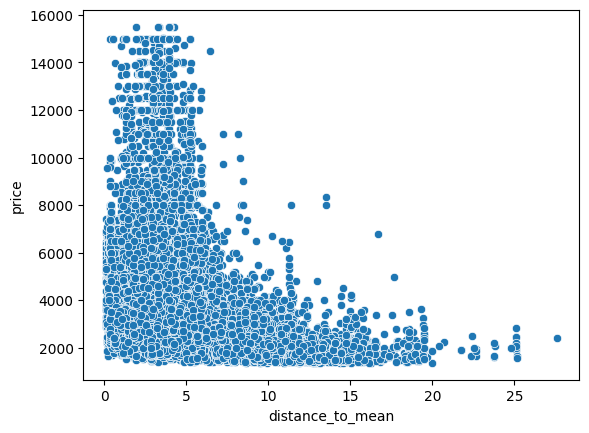

In [8]:
sns.scatterplot(data=df,x='distance_to_mean',y='price');

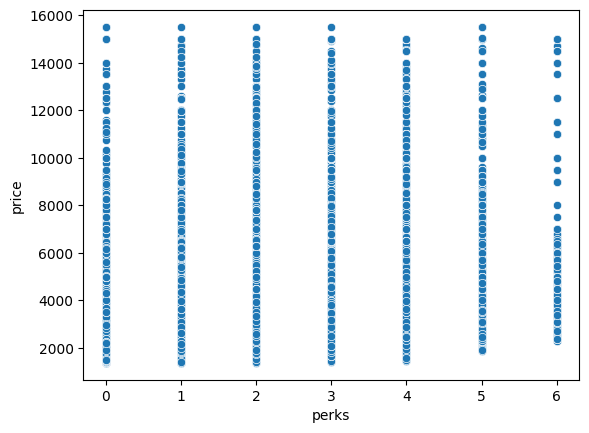

In [9]:
sns.scatterplot(data=df,x='perks',y='price');

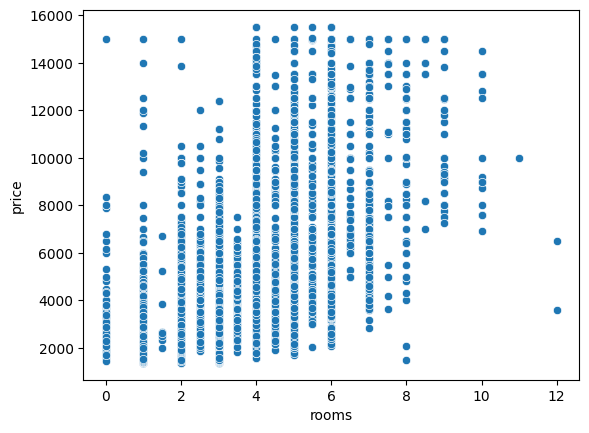

In [10]:
sns.scatterplot(data=df,x='rooms',y='price');

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'price'`.

**Note:** In contrast to the last module project, this time you should include _all_ the numerical features in your dataset.

In [11]:
X = df.select_dtypes('number').drop(columns='price')
y = df['price']

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from April and May 2016.
- Your test set should include data from June 2016.

In [12]:
df.sort_index(inplace=True)
df

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,...,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,distance_to_mean,perks,rooms
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,...,0,0,0,0,0,0,0,2.816934,2,2.0
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,...,0,0,0,0,0,0,0,0.877776,0,1.0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,...,0,0,0,0,0,0,1,1.683028,2,5.0
2016-04-01 23:26:07,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,...,0,0,0,0,0,0,1,4.805683,2,2.0
2016-04-02 00:48:13,1.0,1,Phenomenal deal of the century!! This spacious...,E 88th street,40.7784,-73.9491,2400,401 E 88th street,medium,1,...,0,0,0,0,0,0,0,3.668392,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-29 17:47:34,1.0,2,"Newly renovated, clean, quiet & very bright 2...",At Thompson St,40.7261,-74.0014,3045,132 Thompson St #20,medium,0,...,0,0,0,0,0,0,0,3.648003,0,3.0
2016-06-29 17:56:12,1.0,1,Historic conversion in Greenpoint with awesome...,"100 Dupont St, Brooklyn, NY 11222",40.7358,-73.9560,2648,100 Dupont St,low,1,...,0,0,0,0,0,0,0,2.174612,2,2.0
2016-06-29 18:14:48,1.0,1,"Large, sunny one bedroom apartment with a sepa...",West 45th St. and 8th Ave.,40.7597,-73.9890,2650,305 West 45th St.,low,1,...,0,0,0,0,0,0,0,1.697243,2,2.0


In [13]:
training_cutoff = '2016-06-01'
mask = X.index < training_cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30806, 31) (30806,) (16454, 31) (16454,)


# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model. First, calculate the mean of `y_train`. Next, create a list `y_pred` that has the same length as `y_train` and where every item in the list is the mean. Finally, use `mean_absolute_error` to calculate your baseline.

In [15]:
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 1202.398300781848


# IV. Build Model

**Task 6:** Build and train a `LinearRegression` model named `model` using your feature matrix `X_train` and your target vector `y_train`.

In [16]:
# Step 1: Import predictor class


# Step 2: Instantiate predictor
model = LinearRegression()

# Step 3: Fit predictor on the (training) data
model.fit(X_train, y_train)

LinearRegression()

# V. Check Metrics

**Task 7:** Calculate the training and test mean absolute error for your model.

In [17]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))

print('Training MAE:', training_mae)
print('Test MAE:', test_mae)

Training MAE: 669.0270153597417
Test MAE: 674.9005280544153


**Task 8:** Calculate the training and test $R^2$ score for your model.

In [18]:
training_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)

print('Training MAE:', training_r2)
print('Test MAE:', test_r2)

Training MAE: 0.6338034795092068
Test MAE: 0.6445638270791278


# VI. Communicate Results

**Stretch Goal:** What are the three most influential coefficients in your linear model? You should consider the _absolute value_ of each coefficient, so that it doesn't matter if it's positive or negative.

In [19]:
pd.Series(model.coef_, index=X_train.columns).sort_values(key=abs)

common_outdoor_space    3.182587e+01
pre-war                -5.261928e+01
cats_allowed           -6.792475e+01
garden_patio           -7.480713e+01
latitude                8.722468e+01
distance_to_mean       -9.370703e+01
new_construction       -1.002461e+02
loft                    1.171817e+02
outdoor_space          -1.188081e+02
no_fee                 -1.502124e+02
dogs_allowed            1.522800e+02
fitness_center          1.683120e+02
exclusive               1.810512e+02
roof_deck              -1.855218e+02
terrace                 2.063936e+02
dining_room             2.208555e+02
laundry_in_building    -2.543933e+02
hardwood_floors        -2.605471e+02
wheelchair_access       2.990913e+02
high_speed_internet    -3.357861e+02
longitude              -9.157120e+03
balcony                 1.603315e+12
perks                  -1.603315e+12
dishwasher              1.603315e+12
swimming_pool           1.603315e+12
elevator                1.603315e+12
doorman                 1.603315e+12
l